# Model Testing

## Importing the libraries

In [1]:
import time
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
from skimage import io, color, transform
import dlib

import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms.functional as TF

## Constants

In [2]:
def read_labels(filename):
    return np.loadtxt(filename, comments=("version:", "n_points:", "{", "}"))

In [3]:
image_path = r"test_image_path"
landmarks_path = r"test_labels_path"
detector = dlib.get_frontal_face_detector()

# model = r"C:\\Users\\nicol\\Documents\\Master TAID\\MLAV\\Proiect\\face_landmarks.pth"


## Network

In [4]:
class Network(nn.Module):
    # num_classes = 92 because 46 landmarks X 2 coordinates = 92
    def __init__(self,num_classes=92):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18(pretrained = False)
        
        # input channel count = 1 for grayscale images
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [5]:
my_network = Network()
my_network.load_state_dict(torch.load(model, map_location=torch.device('cpu')))
my_network.eval()

Network(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

## Images

In [6]:
images = os.listdir(image_path)
print(images)

['196a.jpg', '196b.jpg', '197a.jpg', '197b.jpg', '198a.jpg', '198b.jpg', '199a.jpg', '199b.jpg', '200a.jpg', '200b.jpg']


In [7]:
landmarks = os.listdir(landmarks_path)
print(landmarks)

['196a.pts', '196b.pts', '197a.pts', '197b.pts', '198a.pts', '198b.pts', '199a.pts', '199b.pts', '200a.pts', '200b.pts']


In [8]:
def get_crops(image_list, image_path, detector):
    crops = []
    for image in image_list:
        img = io.imread(image_path + "\\" + image)
        detection = detector(img, 1)
        crop = {
            'left': detection[0].left(), 
            'top': detection[0].top(), 
            'height': detection[0].bottom() - detection[0].top(), 
            'width': detection[0].right() - detection[0].left()
        }
        crops.append(crop)
    return crops

crops = get_crops(images, image_path, detector)
print(crops)

[{'left': 18, 'top': 43, 'height': 223, 'width': 223}, {'left': 18, 'top': 43, 'height': 223, 'width': 223}, {'left': 18, 'top': 43, 'height': 223, 'width': 223}, {'left': 18, 'top': 43, 'height': 223, 'width': 223}, {'left': 18, 'top': 43, 'height': 223, 'width': 223}, {'left': 18, 'top': 43, 'height': 223, 'width': 223}, {'left': 18, 'top': 43, 'height': 223, 'width': 223}, {'left': 18, 'top': 43, 'height': 223, 'width': 223}, {'left': 18, 'top': 43, 'height': 223, 'width': 223}, {'left': 18, 'top': 43, 'height': 223, 'width': 223}]


## Predict and visualize images

In [9]:
def draw_landmarks(image, true_landmarks, predict_landmarks):
    plt.figure(figsize = (5,5))
    plt.imshow(image, cmap = 'gray')
    plt.scatter(true_landmarks[:,0], true_landmarks[:,1], c = 'g', s = 5)
    plt.scatter(predict_landmarks[:,0], predict_landmarks[:,1], c = 'r', s = 5)
    plt.show()

In [10]:
def euclidean_distance(true_landmarks, predict_landmarks):
    distances = []
    for i in range(len(true_landmarks)):
        distance = np.sqrt((true_landmarks[i][0] - predict_landmarks[i][0])**2 + (true_landmarks[i][1] - predict_landmarks[i][1])**2)
        distances.append(distance)
    return np.sum(distances)

Euclidean distance sum: 395.92996474108105


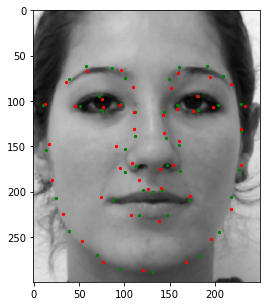

Euclidean distance sum: 260.694813714067


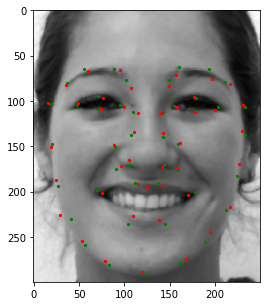

Euclidean distance sum: 359.40211822974965


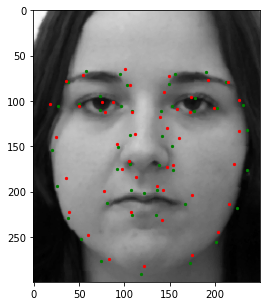

Euclidean distance sum: 312.1026297917687


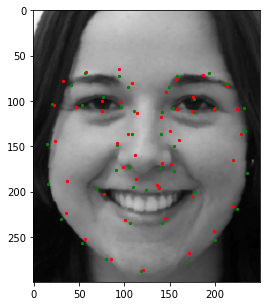

Euclidean distance sum: 412.78392425058024


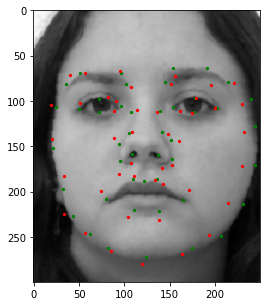

Euclidean distance sum: 339.52248796550276


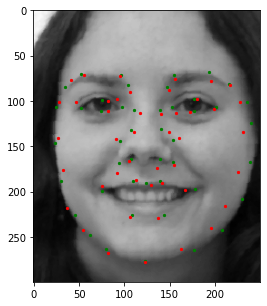

Euclidean distance sum: 397.7746071624201


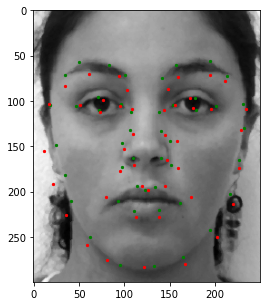

Euclidean distance sum: 356.18117276026595


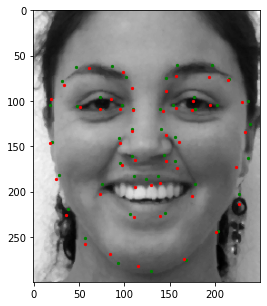

Euclidean distance sum: 309.2674350315082


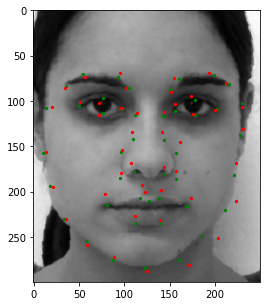

Euclidean distance sum: 264.08200081173777


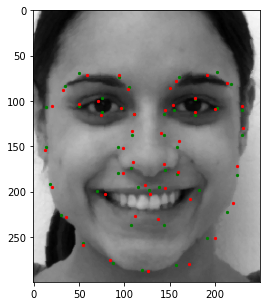

In [11]:
for i, image_name in enumerate(images):
    image = io.imread(image_path + "\\" + image_name)
    true_landmarks = read_labels(landmarks_path + "\\" + landmarks[i])
    display_image = image.copy()
    
    x = crops[i]['left']
    y = crops[i]['top']
    w = crops[i]['width']
    h = crops[i]['height']
    image = image[y:y+h, x:x+w]
    
    image = TF.resize(Image.fromarray(image), size=(224, 224))
    image = TF.to_tensor(image)
    image = TF.normalize(image, [0.5], [0.5])

    with torch.no_grad():
        predict_landmarks = my_network(image.unsqueeze(0))
        
    predict_landmarks = (predict_landmarks.view(46,2).detach().numpy() + 0.5) * np.array([[w, h]]) + np.array([[x, y]])
    
    print("Euclidean distance sum:", euclidean_distance(true_landmarks, predict_landmarks))
    draw_landmarks(display_image, true_landmarks, predict_landmarks)